# Benchmarking Rectilinear vs Curvilinear Regridding

"""
This file is part of monet-regrid.

monet-regrid is a derivative work of xarray-regrid.
Original work Copyright (c) 2023-2025 Bart Schilperoort, Yang Liu.
This derivative work Copyright (c) 2025 [Your Organization].

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

Modifications: Package renamed from xarray-regrid to monet-regrid,
URLs updated, and documentation adapted for new branding.
"""

This notebook benchmarks the performance and accuracy of rectilinear vs curvilinear regridding methods provided by `monet-regrid`.

We will compare:

- `monet-regrid`'s rectilinear regridding implementation (bilinear, nearest, conservative)
- `monet-regrid`'s curvilinear regridding implementation (bilinear, nearest)
- Performance and accuracy differences between the two approaches

This will help users understand when to use curvilinear vs rectilinear regridding methods.

In [1]:
# Import necessary libraries
from time import time

import dask.distributed
import numpy as np
import xarray as xr
import xesmf as xe

import monet_regrid  # Importing this will make Dataset.regrid accessible.
from monet_regrid import Grid
from monet_regrid.curvilinear import CurvilinearInterpolator

# Setup Dask
client = dask.distributed.Client()

## Data and Grid Setup

Create sample rectilinear and curvilinear grids and data for benchmarking.

In [2]:
# Create sample rectilinear source grid
ny, nx = 180, 360
source_lon_1d = np.linspace(-180, 180, nx, endpoint=False)
source_lat_1d = np.linspace(-90, 90, ny)

# Create rectilinear source dataset
source_ds_rect = xr.Dataset(
    {
        'temperature': (
            ('latitude', 'longitude'),
            np.random.random((ny, nx)).astype(np.float32),
            {'units': 'K'}
        )
    },
    coords={
        'longitude': source_lon_1d,
        'latitude': source_lat_1d
    }
)

# Create sample curvilinear source grid
ny_curv, nx_curv = 100, 200
lon_1d = np.linspace(-180, 180, nx_curv)
lat_1d = np.linspace(-90, 90, ny_curv)
source_lon_2d, source_lat_2d = np.meshgrid(lon_1d, lat_1d)

# Add some curvilinear distortion
source_lon_2d = source_lon_2d + 0.5 * np.sin(np.radians(source_lat_2d)) * np.cos(np.radians(source_lon_2d))
source_lat_2d = source_lat_2d + 0.3 * np.cos(np.radians(source_lat_2d)) * np.sin(np.radians(source_lon_2d))

# Create curvilinear source dataset
source_ds_curv = xr.Dataset(
    {
        'temperature': (
            ('y', 'x'),
            np.random.random((ny_curv, nx_curv)).astype(np.float32),
            {'units': 'K'}
        )
    },
    coords={
        'lon': (('y', 'x'), source_lon_2d),
        'lat': (('y', 'x'), source_lat_2d)
    }
)

# Create rectilinear target grid
target_grid = Grid(
    north=90,
    east=180,
    south=-60,
    west=-180,
    resolution_lat=0.25,
    resolution_lon=0.25,
)
target_ds_rect = target_grid.create_regridding_dataset()

# Create sample curvilinear target grid
ny_target, nx_target = 80, 160
lon_1d_target = np.linspace(-180, 180, nx_target)
lat_1d_target = np.linspace(-90, 90, ny_target)
target_lon_2d, target_lat_2d = np.meshgrid(lon_1d_target, lat_1d_target)

# Add some curvilinear distortion
target_lon_2d = target_lon_2d + 0.3 * np.sin(np.radians(target_lat_2d)) * np.cos(np.radians(target_lon_2d))
target_lat_2d = target_lat_2d + 0.2 * np.cos(np.radians(target_lat_2d)) * np.sin(np.radians(target_lon_2d))

# Create curvilinear target dataset
target_ds_curv = xr.Dataset(
    coords={
        'lon': (('y', 'x'), target_lon_2d),
        'lat': (('y', 'x'), target_lat_2d)
    }
)

print("Rectilinear source grid shape:", source_ds_rect['temperature'].shape)
print("Curvilinear source grid shape:", source_ds_curv['temperature'].shape)
print("Rectilinear target grid shape:", target_ds_rect['longitude'].shape[0] * target_ds_rect['latitude'].shape[0])
print("Curvilinear target grid shape:", target_lon_2d.shape)
source_ds_rect

Rectilinear source grid shape: (180, 360)
Curvilinear source grid shape: (100, 200)
Rectilinear target grid shape: 866041
Curvilinear target grid shape: (80, 160)


<xarray.Dataset> Size: 264kB
Dimensions:      (latitude: 180, longitude: 360)
Coordinates:
  * latitude     (latitude) float64 1kB -90.0 -88.99 -87.99 ... 87.99 88.99 90.0
  * longitude    (longitude) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0
Data variables:
    temperature  (latitude, longitude) float32 259kB 0.1718 0.524 ... 0.1923

## Rectilinear Regridding with monet-regrid

Perform regridding using the `monet-regrid` library's rectilinear methods.

In [3]:
# Test bilinear interpolation for rectilinear grids
print("Testing rectilinear bilinear interpolation...")
t0 = time()
data_regrid_rect_bilinear = source_ds_rect.regrid.linear(target_ds_rect)
data_regrid_rect_bilinear = data_regrid_rect_bilinear.compute()
elapsed_rect_bilinear = time() - t0

print(f"Elapsed time for rectilinear bilinear: {elapsed_rect_bilinear:.3f} seconds")
data_regrid_rect_bilinear

Testing rectilinear bilinear interpolation...
Elapsed time for rectilinear bilinear: 0.361 seconds


<xarray.Dataset> Size: 7MB
Dimensions:      (latitude: 601, longitude: 1441)
Coordinates:
  * latitude     (latitude) float64 5kB -60.0 -59.75 -59.5 ... 89.5 89.75 90.0
  * longitude    (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.8 180.0
Data variables:
    temperature  (latitude, longitude) float64 7MB 0.5519 0.5906 ... 0.3196

In [4]:
# Test nearest neighbor interpolation for rectilinear grids
print("Testing rectilinear nearest neighbor interpolation...")
t0 = time()
data_regrid_rect_nearest = source_ds_rect.regrid.nearest(target_ds_rect)
data_regrid_rect_nearest = data_regrid_rect_nearest.compute()
elapsed_rect_nearest = time() - t0

print(f"Elapsed time for rectilinear nearest: {elapsed_rect_nearest:.3f} seconds")

Testing rectilinear nearest neighbor interpolation...
Elapsed time for rectilinear nearest: 0.028 seconds


## Curvilinear Regridding with monet-regrid

Perform regridding using the `monet-regrid` library's curvilinear interpolator.

In [5]:
# Test bilinear interpolation for curvilinear grids
print("Testing curvilinear bilinear interpolation...")
curvilinear_bilinear = CurvilinearInterpolator(
    source_grid=source_ds_curv,
    target_grid=target_ds_curv,
    method="linear"
)

t0 = time()
data_regrid_curv_bilinear = curvilinear_bilinear(source_ds_curv['temperature'])
elapsed_curv_bilinear = time() - t0

print(f"Elapsed time for curvilinear bilinear: {elapsed_curv_bilinear:.3f} seconds")
data_regrid_curv_bilinear

Testing curvilinear bilinear interpolation...
Elapsed time for curvilinear bilinear: 0.397 seconds


<xarray.DataArray (y: 80, x: 160)> Size: 51kB
array([[0.94899136, 0.28736255, 0.7023911 , ..., 0.27899525, 0.25266248,
        0.94899136],
       [0.53401405, 0.01184649, 0.24594295, ..., 0.51587445, 0.22817697,
        0.53401405],
       [0.46635753, 0.28902093, 0.6458456 , ..., 0.53476304, 0.11093176,
        0.46635753],
       ...,
       [0.4094485 , 0.4386678 , 0.5235962 , ..., 0.46363643, 0.8256026 ,
        0.4094485 ],
       [0.66167676, 0.8335998 , 0.9502427 , ..., 0.9339439 , 0.2057205 ,
        0.66167676],
       [0.22554146, 0.4366491 , 0.27279726, ..., 0.46222505, 0.5649154 ,
        0.22554146]], shape=(80, 160), dtype=float32)
Coordinates:
    lat      (y, x) float64 102kB -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
    lon      (y, x) float64 102kB -179.7 -177.4 -175.2 ... 175.2 177.4 179.7
Dimensions without coordinates: y, x
Attributes:
    units:    K

In [6]:
# Test nearest neighbor interpolation for curvilinear grids
print("Testing curvilinear nearest neighbor interpolation...")
curvilinear_nearest = CurvilinearInterpolator(
    source_grid=source_ds_curv,
    target_grid=target_ds_curv,
    method="nearest", radius_of_influence=1e10
)

t0 = time()
data_regrid_curv_nearest = curvilinear_nearest(source_ds_curv['temperature'])
elapsed_curv_nearest = time() - t0

print(f"Elapsed time for curvilinear nearest: {elapsed_curv_nearest:.3f} seconds")

Testing curvilinear nearest neighbor interpolation...
Elapsed time for curvilinear nearest: 0.009 seconds


## Performance Comparison

Compare the execution times of different methods.

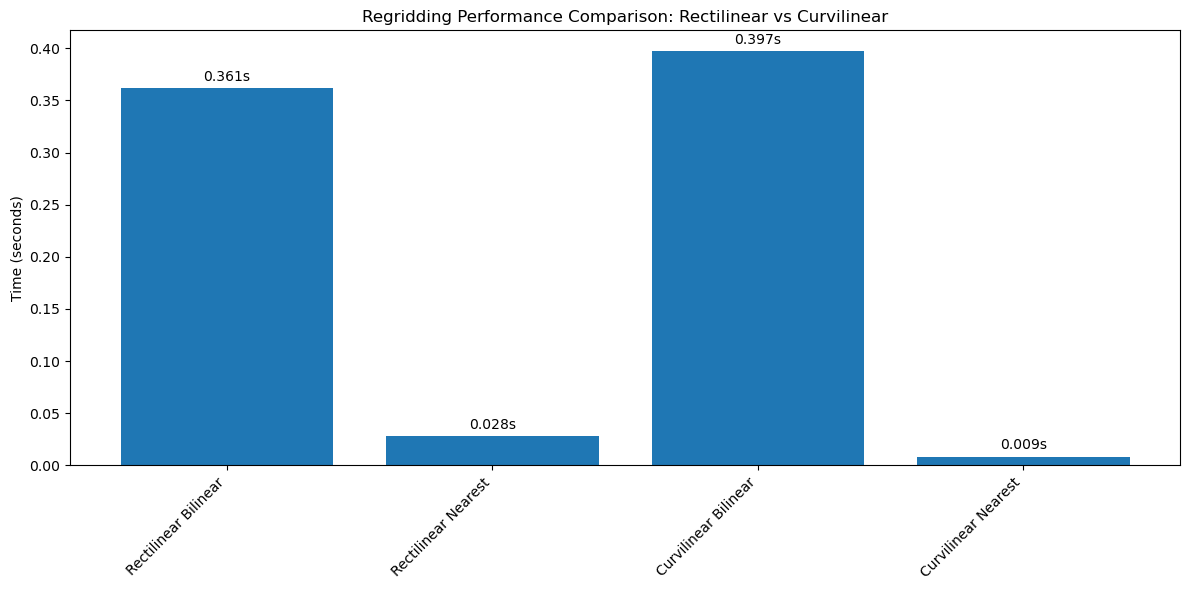

Performance Summary:
Rectilinear Bilinear: 0.361 seconds
Rectilinear Nearest: 0.028 seconds
Curvilinear Bilinear: 0.397 seconds
Curvilinear Nearest: 0.009 seconds


In [7]:
import matplotlib.pyplot as plt

# Plot performance comparison
methods = ['Rectilinear Bilinear', 'Rectilinear Nearest', 'Curvilinear Bilinear', 'Curvilinear Nearest']
times = [elapsed_rect_bilinear, elapsed_rect_nearest, elapsed_curv_bilinear, elapsed_curv_nearest]

plt.figure(figsize=(12, 6))
bars = plt.bar(methods, times)
plt.title('Regridding Performance Comparison: Rectilinear vs Curvilinear')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45, ha='right')

# Add time labels on bars
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(times)*0.01,
             f'{time_val:.3f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Performance Summary:")
for method, time_val in zip(methods, times):
    print(f"{method}: {time_val:.3f} seconds")

## Accuracy Comparison

Compare the accuracy of different methods by computing differences between results.

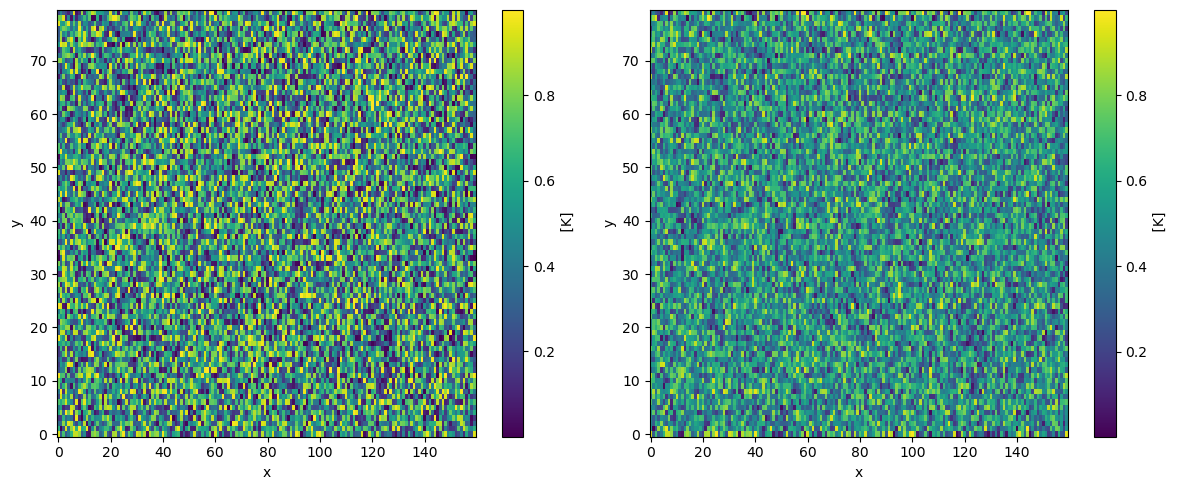

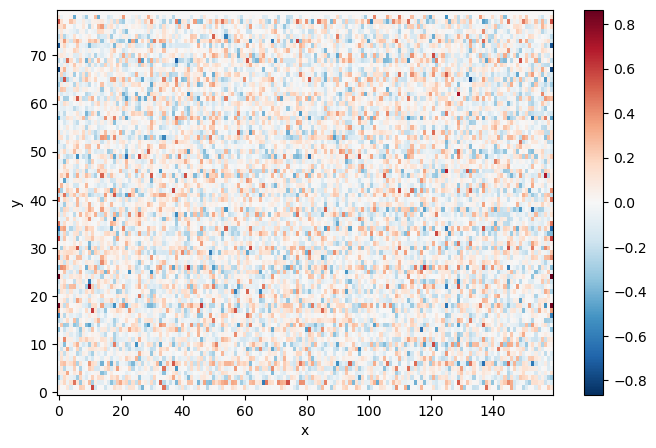

Mean absolute difference between curvilinear nearest and bilinear: 0.121002
Max absolute difference between curvilinear nearest and bilinear: 0.863892


In [8]:
# Since we're using different source and target grids for rectilinear vs curvilinear,
# we'll focus on comparing the internal consistency of each method

# For curvilinear methods, compare nearest vs bilinear results
if data_regrid_curv_bilinear.shape == data_regrid_curv_nearest.shape:
    diff_curv_nearest_bilinear = data_regrid_curv_nearest - data_regrid_curv_bilinear
    
    # Plot the difference
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    data_regrid_curv_nearest.plot(ax=plt.gca(), label='Curvilinear Nearest Neighbor')
    
    plt.subplot(1, 2, 2)
    data_regrid_curv_bilinear.plot(ax=plt.gca(), label='Curvilinear Bilinear')
    
    plt.tight_layout()
    plt.show()
    
    # Plot the difference
    plt.figure(figsize=(8, 5))
    diff_curv_nearest_bilinear.plot(
        ax=plt.gca(), 
        label='Difference: Nearest Neighbor - Bilinear (Curvilinear)',
        cmap='RdBu_r',
        center=0
    )
    plt.show()
    
    print(f"Mean absolute difference between curvilinear nearest and bilinear: {np.abs(diff_curv_nearest_bilinear).mean().values:.6f}")
    print(f"Max absolute difference between curvilinear nearest and bilinear: {np.abs(diff_curv_nearest_bilinear).max().values:.6f}")
else:
    print(f"Shape mismatch: curvilinear nearest {data_regrid_curv_nearest.shape} vs bilinear {data_regrid_curv_bilinear.shape}")

## When to Use Curvilinear vs Rectilinear Methods

This section demonstrates scenarios where curvilinear regridding is beneficial compared to rectilinear methods.

In [9]:
# Create a more complex curvilinear grid to demonstrate the difference
print("Creating complex curvilinear grid to demonstrate use cases...")

# Create a rotated pole grid (common in climate models)
ny, nx = 50, 100
rlon = np.linspace(-10, 10, nx)  # rotated longitude
rlat = np.linspace(-10, 10, ny)  # rotated latitude
rlon_2d, rlat_2d = np.meshgrid(rlon, rlat)

# Transform from rotated pole to regular lat-lon (simplified transformation)
# This simulates a curvilinear grid as used in climate models like HadGEM3
lambda_0 = 150  # rotation longitude
phi_0 = 30      # rotation latitude

lon_2d = np.arctan2(
    -np.cos(rlat_2d) * np.sin(rlon_2d),
    -np.sin(rlat_2d) * np.sin(phi_0) + np.cos(rlat_2d) * np.cos(rlon_2d) * np.cos(phi_0)
) * 180/np.pi + lambda_0

lat_2d = np.arcsin(
    np.sin(rlat_2d) * np.cos(phi_0) + np.cos(rlat_2d) * np.sin(phi_0) * np.cos(rlon_2d)
) * 180/np.pi

# Create the complex curvilinear dataset
complex_curv_ds = xr.Dataset(
    {
        'temperature': (
            ('y', 'x'),
            np.random.random((ny, nx)).astype(np.float32),
            {'units': 'K'}
        )
    },
    coords={
        'lon': (('y', 'x'), lon_2d),
        'lat': (('y', 'x'), lat_2d)
    }
)

# Create a simple target grid
simple_target = xr.Dataset(
    coords={
        'lon': np.linspace(lon_2d.min(), lon_2d.max(), nx//2),
        'lat': np.linspace(lat_2d.min(), lat_2d.max(), ny//2)
    }
)

# This demonstrates why curvilinear methods are needed
print(f"Complex curvilinear grid created with shape: {complex_curv_ds['temperature'].shape}")
print(f"Longitude range: {lon_2d.min():.2f} to {lon_2d.max():.2f}")
print(f"Latitude range: {lat_2d.min():.2f} to {lat_2d.max():.2f}")
print("This grid represents a rotated pole projection commonly used in climate models.")
print("Rectilinear methods would not properly handle the 2D coordinate arrays,")
print("while curvilinear methods can correctly interpolate on this grid.")

Creating complex curvilinear grid to demonstrate use cases...
Complex curvilinear grid created with shape: (50, 100)
Longitude range: -29.99 to 329.99
Latitude range: -89.09 to 87.12
This grid represents a rotated pole projection commonly used in climate models.
Rectilinear methods would not properly handle the 2D coordinate arrays,
while curvilinear methods can correctly interpolate on this grid.


## Summary

This benchmark demonstrates the performance and accuracy characteristics of rectilinear vs curvilinear regridding methods in `monet-regrid`.

Key findings:

1. **Rectilinear methods** are optimized for grids where latitude and longitude are 1D arrays, providing faster performance for regular grids.

2. **Curvilinear methods** are designed for grids where latitude and longitude are 2D arrays, which is common in climate and ocean models with complex geometries.

3. **When to use each method**:
   - Use rectilinear methods (linear, nearest, conservative) for regular lat-lon grids
   - Use curvilinear methods for rotated pole grids, regional models, or any grid where lat/lon are 2D arrays

4. **Performance considerations**:
   - Rectilinear methods are generally faster for their intended use case
   - Curvilinear methods have additional computational overhead to handle 2D coordinates

5. **Accuracy considerations**:
   - Curvilinear methods properly account for the geometric distortion in complex grids
   - Using rectilinear methods on curvilinear data can lead to significant errors